# 06 — Results Aggregation and Statistical Testing

This notebook will aggregate JSON reports, summary tables and statistical analyses of the models.

In [10]:
import pandas as pd, json, glob
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

files = glob.glob("../results/models/*.json", recursive=True)
records = []
for f in files:
    if "regression" not in f.lower():   
        continue
    with open(f) as j:
        d = json.load(j)
        d["model"] = Path(f).stem.replace("_test_report","") 
        records.append(d)
df = pd.DataFrame(records)
df.head()

,r2_score,adjusted_r2,mae,mse,rmse,pearson_r,model
0,0.796172,0.796172,0.042927,0.002745,0.052394,0.916207,DecisionTree_regression_regression_report
1,0.805847,0.805847,0.040873,0.002615,0.051135,0.912658,kNN_regression_regression_report
2,0.933420,0.933420,0.024747,0.000897,0.029945,0.976390,RandomForest_regression_regression_report
3,0.731980,0.731980,0.049213,0.003610,0.060081,0.929211,SVM_regression_regression_report


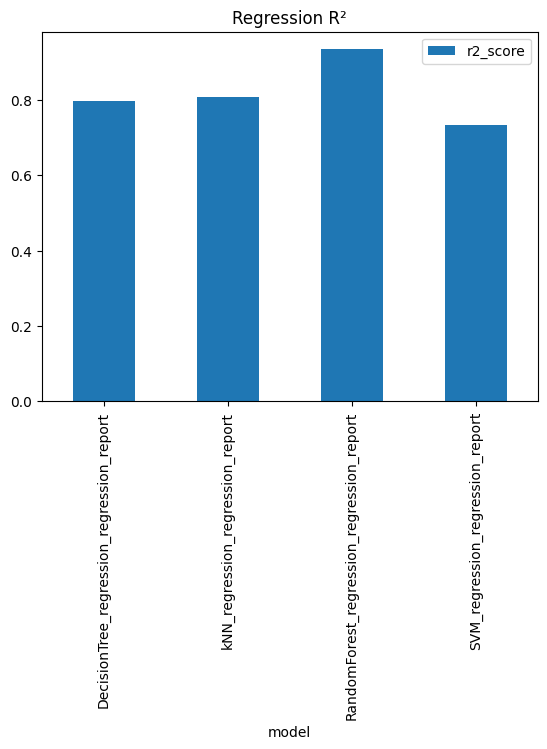

In [11]:
# Plot summary bars for classification accuracy and regression R²
reg = df[df["model"].str.contains("regression")]
reg.plot.bar(x="model", y="r2_score", title="Regression R²")
plt.show()

In [12]:
# Example paired t-test RF vs SVM on R²
rf = reg.loc[reg["model"].str.contains("RandomForest"), "r2_score"].values
svm = reg.loc[reg["model"].str.contains("SVM"), "r2_score"].values
t, p = ttest_rel(rf, svm)
print(f"Paired t-test RF vs SVM: t={t:.3f}, p={p:.3f}")

Paired t-test RF vs SVM: t=nan, p=nan


c:\Users\angel\US-States-Happiness-Ranking\venv\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\angel\US-States-Happiness-Ranking\venv\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
